# Examples SuperSmoother

## Periodic SuperSmoother

One feature of the SuperSmoother is its ability to handle periodic signals. We'll demonstrate this here:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults.
# This can be safely commented-out if seaborn is not installed
import seaborn; seaborn.set()

In [3]:
# Create a periodic function with interesting structure

def func(t, period):
    phase = t / period
    modphase = phase + 0.1 * np.sin(2 * np.pi * phase)
    return np.sin(2 * np.pi * modphase)

In [4]:
rng = np.random.RandomState(42)
t = 50 * rng.rand(100)
period = 10
dy = 0.1
y = func(t, period) + dy * rng.randn(len(t))

phase = t % period

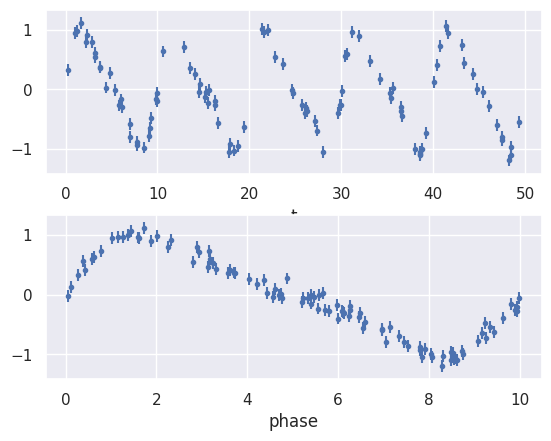

In [5]:
def plot_data():
    fig, ax = plt.subplots(2)
    fig.subplots_adjust(hspace=0.25)

    # Plot the data first
    ax[0].errorbar(t, y, dy, fmt='.')
    ax[0].set_xlabel('t')

    # Plot the phased data below
    ax[1].errorbar(phase, y, dy, fmt='.')
    ax[1].set_xlabel('phase');
    return ax

plot_data();

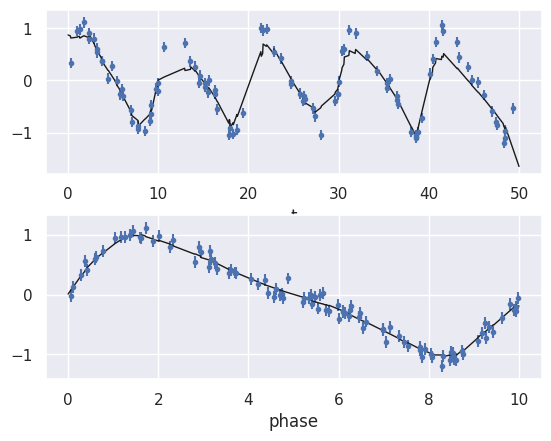

In [6]:
from supersmoother import SuperSmoother

phase_fit = np.linspace(0, period, 1000)
t_fit = np.linspace(0, 50, 1000)

model = SuperSmoother()
y_t = model.fit(t, y, dy).predict(t_fit)
y_phase = model.fit(phase, y, dy).predict(phase_fit)

ax = plot_data()
ax[0].plot(t_fit, y_t, '-k', lw=1)
ax[1].plot(phase_fit, y_phase, '-k', lw=1);

Notice there are some issues here. In the upper plot, the data: the data is sparse in some locations, which makes for a poor model. Also, at the edges there is some extrapolation which does not look good.

In the bottom, phased plot, things look a bit better. But there is a discontinuity between the left and right edges because the algorithm is not considering points across the boundary.

We can improve on these by passing a period argument, which enforces periodicity of the smoothed model:

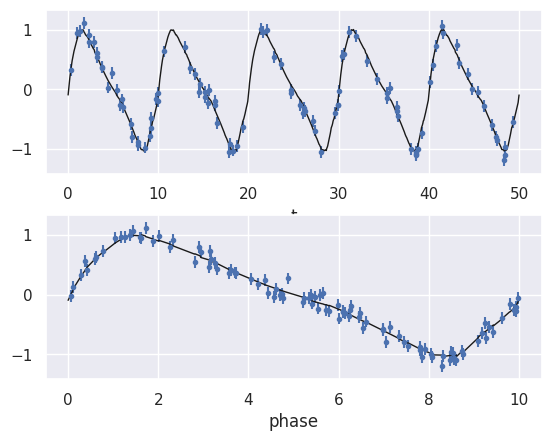

In [7]:
model = SuperSmoother(period=period)

y_t = model.fit(t, y, dy).predict(t_fit)
y_phase = model.fit(phase, y, dy).predict(phase_fit)

ax = plot_data()
ax[0].plot(t_fit, y_t, '-k', lw=1)
ax[1].plot(phase_fit, y_phase, '-k', lw=1);

## More Examples

Supersmoother is a non-parametric locally-linear smooth in which the size of the local neighborhood is tuned to the characteristics of the data. It was introduced in 1984 by JH Friedman in a paper titled "A Variable Span Smoother" ([pdf](https://www.slac.stanford.edu/cgi-bin/getdoc/slac-pub-3477.pdf))

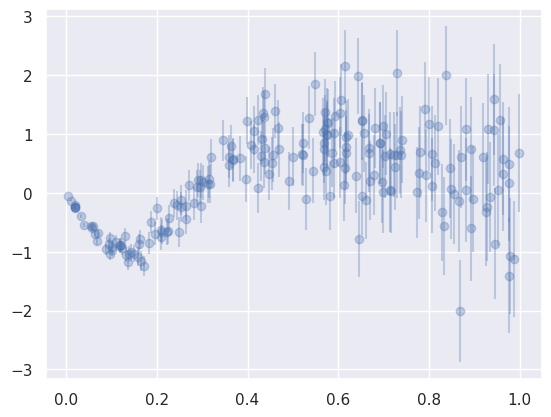

In [8]:
from supersmoother import SuperSmoother, LinearSmoother

def make_test_set(N=200, rseed_x=None, rseed_y=None):
    """Code to generate the test set from Friedman 1984"""
    rng_x = np.random.RandomState(rseed_x)
    rng_y = np.random.RandomState(rseed_y)
    x = rng_x.rand(N)
    dy = x
    y = np.sin(2 * np.pi * (1 - x) ** 2) + dy * rng_y.randn(N)
    return x, y, dy
    

t, y, dy = make_test_set(rseed_x=0, rseed_y=1)
plt.errorbar(t, y, dy, fmt='o', alpha=0.3);

In [9]:
# fit the supersmoother model
model = SuperSmoother()
model.fit(t, y, dy)

# find the smoothed fit to the data
tfit = np.linspace(0, 1, 1000)
yfit = model.predict(tfit)

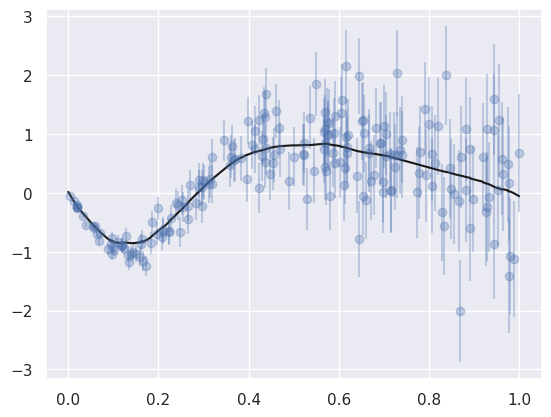

In [10]:
# Show the smoothed model of the data
plt.errorbar(t, y, dy, fmt='o', alpha=0.3)
plt.plot(tfit, yfit, '-k');

### Exploring the component smooths

The supersmoother is based on initial smooths where the size of each local neighborhood is some fraction **f** of the total dataset. In analogy with audio frequencies, Friedman calls these the tweeter (*f=0.05*), the midrange (*f=0.2*), and the woofer (*f=0.5*). We can visualize these individual fits here:

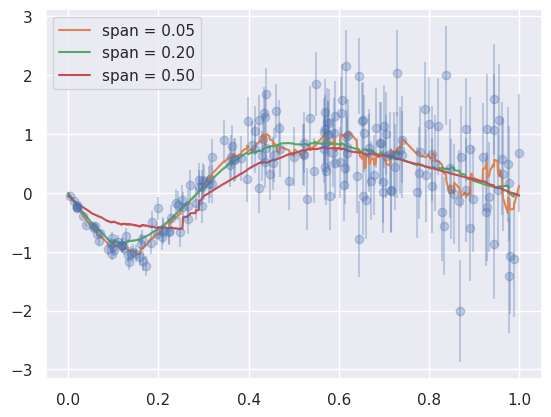

In [11]:
plt.errorbar(t, y, dy, fmt='o', alpha=0.3)

for smooth in model.primary_smooths:
    plt.plot(tfit, smooth.predict(tfit),
             label='span = {0:.2f}'.format(smooth.span))
plt.legend();

The final supersmoother value uses cross-validation to select the best smoothing value at each time for the dataset. We can show these smoothed span values as follows:

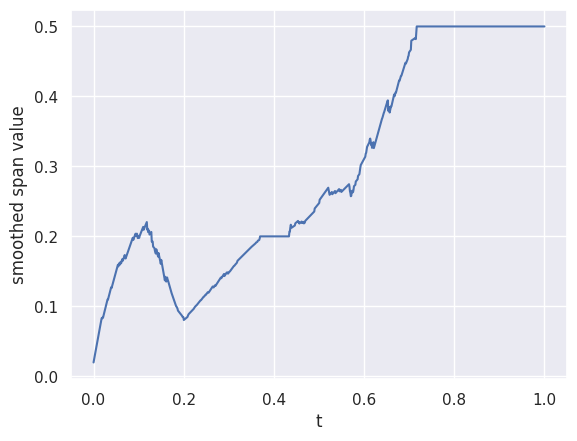

In [12]:
t = np.linspace(0, 1, 1000)
plt.plot(t, model.span(t))
plt.xlabel('t')
plt.ylabel('smoothed span value');

These spans are fit to the particular data realization. Friedman chose to use 1000 realizations of the smoother to get a better estimate of how the span varies. We'll do the same here:

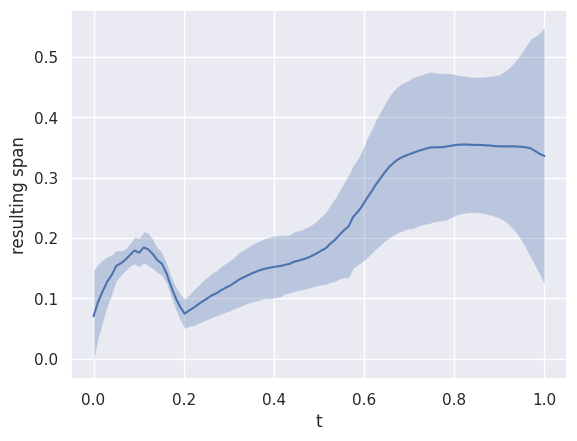

In [13]:
N = 1000
span = span2 = 0

tfit = np.linspace(0, 1, 100)

for rseed in np.arange(N):
    t, y, dy = make_test_set(rseed_x=0, rseed_y=rseed)
    model = SuperSmoother().fit(t, y, dy)
    span += model.span(tfit)
    span2 += model.span(tfit) ** 2
    
mean = span / N
std = np.sqrt(span2 / N - mean ** 2)
plt.plot(tfit, mean)
plt.fill_between(tfit, mean - std, mean + std, alpha=0.3)
plt.xlabel('t')
plt.ylabel('resulting span');

### Bass Enhancement

The degree of smoothing can be tuned with the bass enhancement feature. This is a number  which lies between 0 and 10, with 10 being a much smoother curve

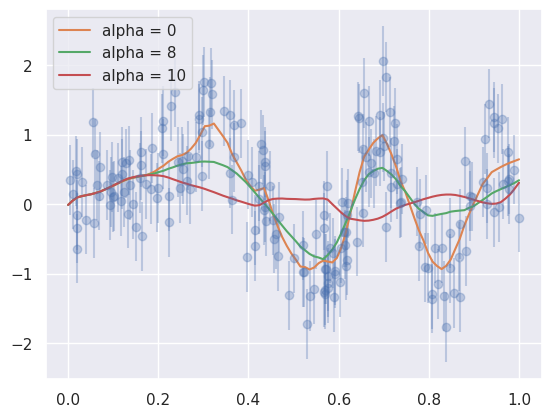

In [14]:
rng = np.random.RandomState(0)
t = rng.rand(200)
dy = 0.5
y = np.sin(5 * np.pi * t ** 2) + dy * rng.randn(200)

plt.errorbar(t, y, dy, fmt='o', alpha=0.3)

for alpha in [0, 8, 10]:
    smoother = SuperSmoother(alpha=alpha)
    smoother.fit(t, y, dy)
    plt.plot(tfit, smoother.predict(tfit),
             label='alpha = {0}'.format(alpha))
plt.legend(loc=2);

The effect of the smoothing is not linear: i.e. a change from 0 to 1 has much less effect than a change from 9 to 10.